In [165]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Set Up Project Variables

In [166]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'


## Utility Functions

In [169]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=197
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c

def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # im = image class with bitmap of temperature field
    # lowercutoff = lower horizontal cutoff
    # uppercutoff = upper horizontal cutoff
    # delta = strip parallel to diagonal
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[
        (im.persistence_diagrams['sub']['dim']==0) & 
        ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & 
        (im.persistence_diagrams['sub']['death']>=lowercutoff) & 
        (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[
        (im.persistence_diagrams['sub']['dim']==1) & 
        ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & 
        (im.persistence_diagrams['sub']['birth']>=lowercutoff) & 
        (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[
        (im.persistence_diagrams['sup']['dim']==0) & 
        ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & 
        (im.persistence_diagrams['sup']['death']>=127) & 
        (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_upper_saddles['type'] = 'saddles_upper'
    ph_tmp = im.persistence_diagrams['sup'].loc[
        (im.persistence_diagrams['sup']['dim']==1) & 
        ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & 
        (im.persistence_diagrams['sup']['birth']>=127) & 
        (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    # Get matrix of 
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[ph_lower_saddles['row'], ph_lower_saddles['col']] = -1
    saddle_matrix[ph_upper_saddles['row'], ph_upper_saddles['col']] = 1
    
    # Crop saddles
    c = cropping_region()
    saddle_matrix = np.multiply(saddle_matrix, c)
    
    saddles_all = pd.DataFrame([ (i,j, saddle_matrix[i,j]) for (i,j) in np.argwhere(saddle_matrix)])
    saddles_all.columns = ['row', 'col', 'type']
    saddles_all.loc[saddles_all.type == -1, 'type'] = 'saddle_lower'
    saddles_all.loc[saddles_all.type == 1, 'type'] = 'saddle_upper'

    return saddles_all


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # im = image class with bitmap of temperature field
    # lowercutoff = lower horizontal cutoff
    # uppercutoff = upper horizontal cutoff
    # delta = strip parallel to diagonal
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[
        (im.persistence_diagrams['sub']['dim']==1) & 
        ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & 
        (im.persistence_diagrams['sub']['death']<=uppercutoff) & 
        (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[
        (im.persistence_diagrams['sup']['dim']==1) & 
        ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & 
        (im.persistence_diagrams['sup']['birth']>=127) & 
        (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1
    

    # Crop plumes
    c = cropping_region()
    plume_matrix = np.multiply(plume_matrix, c)
    
    plumes = pd.DataFrame([ (i,j, 'plume') for (i,j) in np.argwhere(plume_matrix)])
    plumes.columns = ['row', 'col', 'type']

    return plumes

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    # im = image class with bitmap of temperature field
    # sigma = sigma for smoothing for topological defects
    # lowercutoff = lower horizontal cutoff
    # uppercutoff = upper horizontal cutoff
    # delta = strip parallel to diagonal

    im = load_image_data(myproject, idx)
    c = cropping_region()
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(np.multiply(im.orientation_fields[sigma].topological_defects, c))
    im.orientation_fields[sigma].topological_defects_list.loc[im.orientation_fields[sigma].topological_defects_list['type'] == 1, 'type'] = 'td_plus_1'
    im.orientation_fields[sigma].topological_defects_list.loc[im.orientation_fields[sigma].topological_defects_list['type'] == -1, 'type'] = 'td_minus_1'
    
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)
    
    im.defects = pd.concat([im.orientation_fields[sigma].topological_defects_list, im.saddle_points, im.plumes])

    return im


## Annotate the temperature field!

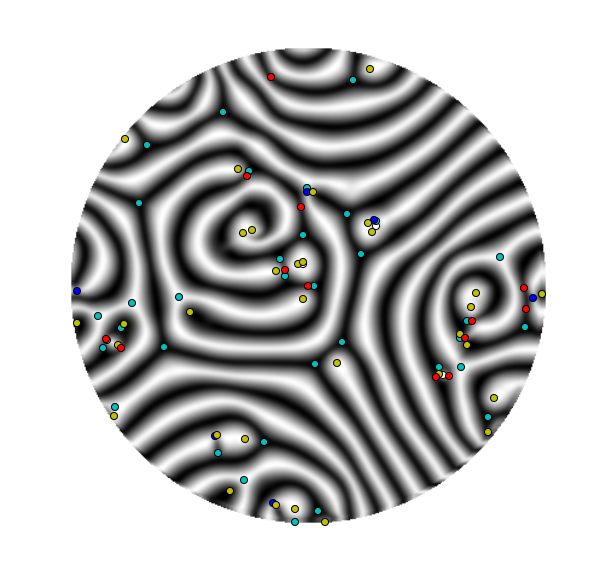

In [170]:
idx = 1000  # Index of image

# Annotation parameters
sigma = 3         # Smoothing for Topological Defects
lowercutoff = 40  # Lower noise 'corner' cutoff
uppercutoff = 195 # Upper noise 'corner' cutoff
delta = 5        # Diagonal noise cutoff

# Load the image and get all of its defects
im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta) 

# Prepare image to plot
c = cropping_region()
plot_image = im.bmp.copy()
plot_image[c==0] = 255

# Plot the image and annotate it with all of the defects!
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
defect_size = 50

plt.imshow(plot_image.T)
plt.axis('off')
plt.set_cmap('gray')

colors = {'td_plus_1':'y', 'td_minus_1':'c', 'saddle_lower':'r', 'saddle_upper':'b', 'plume':'w'}

for defect_type in colors.keys():
    plt.scatter(im.defects.loc[im.defects['type']==defect_type]['row'], 
                im.defects.loc[im.defects['type']==defect_type]['col'], 
                defect_size, colors[defect_type])
